# Восстановление золота из руды / Recovery of gold from ore

В данном проекте, используя машинное обучение и данные золотодобывающей компании, построим прототип модели для повышения эффективности промышленного предприятия. Наша модель будет предсказывать коэффициент восстановления золота из золотосодержащей руды.

__________

In this project, using machine learning and data from a gold mining company, we will build a prototype model to improve the efficiency of an industrial enterprise. Our model will predict the recovery rate of gold from gold ore.

## Подготовка данных / Data preparation

In [6]:
%config IPCompleter.greedy=True
%matplotlib inline
import pandas as pd
import seaborn as sb
import dtale
import dtale.global_state as global_state
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from yellowbrick.regressor import ManualAlphaSelection
from sklearn.ensemble import RandomForestRegressor

In [2]:
# настроим тетрадь для работы / set jupyter notebook for work
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Изучение данных / Data exploration

In [3]:
# пути с файлами / paths to files
orig_path_to_file = '/datasets/'
alter_path_to_file = '/Users/vlad/Documents/Documents Linux/Yandex DS/Projects/YandexPracticum-projects/gold_proj/'

In [4]:
# считаем файлы
try:
    gold_recovery = pd.read_csv(orig_path_to_file+'gold_recovery_full_new.csv', index_col='date')
    gold_recovery_train = pd.read_csv(orig_path_to_file+'gold_recovery_train_new.csv', index_col='date')
    gold_recovery_test = pd.read_csv(orig_path_to_file+'gold_recovery_test_new.csv', index_col='date')
except:
    gold_recovery = pd.read_csv(alter_path_to_file+'gold_recovery_full_new.csv', index_col='date')
    gold_recovery_train = pd.read_csv(alter_path_to_file+'gold_recovery_train_new.csv', index_col='date')
    gold_recovery_test = pd.read_csv(alter_path_to_file+'gold_recovery_test_new.csv', index_col='date')

Посмотрим на данные.

Let's have the first look at the data.

In [7]:
gold_recovery.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

- **Данные** (gold_recovery_full) содержат 19439 строк и 87 колонок. Все колонки имеют тип ***float64***. Колонку с датой назначили в качестве индекса. Дубликатов нет, а общее количество пропусков сотавляет 4481 (23%).

- Колонку с датой можно назначить как индекс (вставили в код со считыванием файлов).

- **Названия колонок** сложные, но необходимо разобраться в структуре их названия, чтобы понять за что обозначает та или иная переменная. Названия состоят из трех частей **[этап].[тип_параметра].[название_параметра]**. Этап - флотация, первичная очистка, вторичная очистка, финальный продукт. Тип параметра - параметры сырья, параметры продукта, параметры текущего сотояния этапа, расчетные характеристики. Название параметра - конецентрация различных элементов, содержание элементов в финальном концентрате, содержание различных элементов в черновом концентрате, содержание различных элементов в отвальных хвостах, сколько было подано флотационных агентов в различные флотационные установки, параметры во флотационных установках (воздух, скорость подачи, размер гранул, уровень жидкости) на различных этапах.

_________

- **Data** (gold_recovery_full) contains 19439 rows and 87 columns. All columns are of type ***float64***. The date column was assigned as an index. There are no duplicates, and the total number of missing values is 4481 (23%).

- A column with a date can be assigned as an index (inserted into the code with reading files).

- **Column names** are complicated, but you need to understand the structure of their names in order to understand what this or that variable stands for. The names consist of three parts **[stage].[parameter_type].[parameter_name]**. Stage - flotation, primary cleaning, secondary cleaning, final product. Parameter type - raw material parameters, product parameters, parameters of the current state of the stage, calculated characteristics. The name of the parameter is the concentration of various elements, the content of elements in the final concentrate, the content of various elements in the crude concentrate, the content of various elements in tailings, how much flotation agents were fed to various flotation units, parameters in flotation units (air, feed rate, granule size, liquid level) at various stages.

### Проверка корректности расчета эффективности обогащения / Checking the correctness of the enrichment efficiency calculation

Проверим на обучающей выборке верно ли рассчитана эффективность обогащения.

Let's check on the training sample whether the enrichment efficiency is calculated correctly.

In [8]:
def recovery_calc(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    return(((C * (F - T)) / (F * (C - T))) * 100)
    

In [9]:
recovery_calculated = pd.Series(gold_recovery_train.apply(recovery_calc, axis=1))
recovery_calculated

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

Найдем MAE между нашими расчетами и значениями в таблице.

Let's find the MAE between our calculations and the values in the table.

In [10]:
mean_absolute_error(gold_recovery_train['rougher.output.recovery'], recovery_calculated)

9.73512347450521e-15

Видно, что разница между табличным значением эффективности обогащения и рассчитанным стремится к 0. Делаем вывод, что эффективность обогащения рассчитана верно.
___________

It can be seen that the difference between the table value of the enrichment efficiency and the calculated one tends to 0. We conclude that the enrichment efficiency is calculated correctly.

### Анализ признаков, недоступных в тестовой выборке / Analysis of features not available in the test sample

Проанализируем каких переменных не хватает в тестовой выборке.

Let's analyze what variables are missing in the test sample.

In [18]:
absent_from_test = list(gold_recovery_train.columns[~(gold_recovery_train.columns.isin(gold_recovery_test))])
print(f'В тестовой выборке отсутствуют {len(absent_from_test)} колонки: / \
{len(absent_from_test)} columns are absent from test dataset:')
absent_from_test

В тестовой выборке отсутствуют 34 колонки: / 34 columns are absent from test dataset:


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют:
- содержание различных элементов в **финальном коцнетрате** и **финальных хвостах**,
- содержание различных веществ в *хвостах* и *концентрате* после **первичной очистки**,
- содержание различных веществ *хвостах* и *концентрате* после **флотации**,
- содержание различных веществ *хвостах* после **вторичной очистки**,
- целевые переменные - **эффективность обогащения после флотации** (rougher.output.recovery) и **финальная эффективность обогащения** (final.output.recovery),
- расчетные характеристики для процесса **флотации**.

В основном, данные переменные описывают параметры продукта на разных этапах. Получить их до обучения модели невозможно, а значит в обучении и тестировании они не могут учавствовать. Удалим их из тренировочного датасета.
________________________

The test sample does not include:
- content of different elements in **final coznetrate** and **final tails**,
- content of various substances in *tails* and *concentrate* after **primary treatment**,
- content of various substances *tails* and *concentrate* after **flotation**,
- content of various substances *tails* after **secondary treatment**,
- target variables - **washing efficiency after flotation** (rougher.output.recovery) and **final washing efficiency** (final.output.recovery),
- design characteristics for the **flotation** process.

Basically, these variables describe the parameters of the product at different stages. It is impossible to get them before training the model, which means that they cannot participate in training and testing. Let's remove them from the training dataset.

### Предобработка данных / Data preprocessing

#### Удаление лишних колонок и добавление целевых переменных / Removing extra columns and adding target variables

Удалим из **обучающей выборки** переменные, отсутствующие в тестовой выборке (кроме целевых переменных). Будет некорректно обучать модель на данных, которые потом не будут подаваться ей для предсказаний.
_______

Let's remove from the **training sample** the variables that are absent in the test sample (except for the target variables). It will be incorrect to train the model on data that will then not be fed to it for predictions.

In [19]:
# удалим целевые переменные из листа с названиями колонок для удаления
# delete the target variables from the sheet with the names of the columns to be deleted
absent_from_test.remove('rougher.output.recovery')
absent_from_test.remove('final.output.recovery')

# удалим оставшиеся колонки
# remove the remaining columns
gold_recovery_train.drop(absent_from_test, axis=1, inplace=True)
gold_recovery_train.shape

(14149, 54)

Добавим в **тестовую выборку** целевые переменные.
______

Let's add target variables to the **test set**.

In [20]:
gold_recovery_test['rougher.output.recovery'] = gold_recovery['rougher.output.recovery']
gold_recovery_test['final.output.recovery'] = gold_recovery['final.output.recovery']
gold_recovery_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.8659

Убедимся, что тренировочный и тестовый наборы содержат одинаковое количество переменных.
_______

Let's make sure that the training and test sets contain the same number of variables.

In [21]:
print(gold_recovery_train.shape[1])
gold_recovery_test.shape[1]

54


54

#### Обработка пропусков / Missing values treatment

Из описания задания мы знаем, что близкие по времени данные часто похожи. Пропуски можно заполнить соседними значениями. Для этого используем методы **ffill** и **bfill**. Будем брать значения до пропуска и после пропуска, суммировать их и делить на два (среднее соседних значений).
________

We know from the job description that data close in time is often similar. Gaps can be filled with adjacent values. To do this, we use the **ffill** and **bfill** methods. We will take the values before the gap and after the gap, sum them up and divide by two (the average of neighboring values).

In [22]:
gold_recovery = (gold_recovery.fillna(method='ffill') + gold_recovery.fillna(method='bfill'))/2
gold_recovery.isna().sum()

final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au                 0
primary_cleaner.output.tail_ag                  

In [23]:
gold_recovery_train = (gold_recovery_train.fillna(method='ffill') + gold_recovery_train.fillna(method='bfill'))/2
gold_recovery_train.isna().sum()

final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Таким же способом заполним пропуски в тестовых данных.
_______

Fill in the gaps in the test data in the same way.

In [24]:
gold_recovery_test = (gold_recovery_test.fillna(method='ffill') + gold_recovery_test.fillna(method='bfill'))/2
gold_recovery_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

Данные подготовлены к дальнейшим этапам.
_____

The data is ready for the following analysis.

## Анализ данных / Data analysis

### ИАД / Exploatory data analysis

Воспользуемся библиотекой **dtale** для автоматизации исследовательского анализа данных. Библиотека позволяет в интерактивном режиме проводить ИАД. Необходимо нажать меню сверху слева в таблице и выбрать интересующее действие с данными.

Поскольку DTALE интерактивен, мы можем экспортировать из него изображения. Я публикую их ниже. Интерактивный режим не может быть воспроизведен, если ipynb открыт в GitHub.
______

Let's use the **dtale** library to automate exploratory data analysis. The library allows you to interactively conduct EAD. You must click the menu at the top left of the table and select the desired action with the data.

Since DTALE is interactive we can export images from it. I am posting them below. INteractive mode can not be reproduced if ipynb is opened in GitHub.

In [25]:
report = dtale.show(gold_recovery_train)
report

Исследуем корреляции между переменными и между переменными и таргетами в тренировочном датасете.
______

We explore correlations between variables and between variables and targets in the training dataset.

![Correlations](correlations.png)

1) Целевая переменная **rougher.output.recovery** имеет значимую корреляцию с (указан коэффициент Пиросна):
- primary_cleaner.input.sulfate (0.27) - слабая положительная.

Выход продукта после флотации зависит от количества очищающих агентов, подаваемых на следующем за флотацией этапе - первичной очистке. Странно. 

Значимых отрицательных корреляций нет.

2) Целевая переменная **final.output.recovery** имеет значимую корреляцию с (указан коэффициент Пиросна):
- primary_cleaner.input.sulfate (0.39) - слабая положительная,
- rougher.input.floatbank10_xanthate (0.33) - слабая положительная,
- rougher.input.feed_ag (0.31) - cлабая положительная,
- rougher.input.feed_au (0.31) -  cлабая положительная,
- rougher.input.floatbank11_xanthate (0.28) - слабая положительная,
- rougher.input.feed_sol (0.26) - слабая положительная.

Здесь все логично. Финальный выход золота зависит от количества золота в исходном сырье, количества побочных металлов в исходном сырье, и количестве очищающего агента, подаваемого на этапе флотации в определенную флотационную установку. Также, завист от количества очищающего агента, подаваемого на этапе первичной очистки.

Значимых отрицательных корреляций нет.

3) Между некоторыми переменными наблюдаются сильные корреляции (мультиколлинеарность):

Это значит, что мы можем восстановить переменную по значениям других переменных. Также, это явление влияет на качество некоторых моделей (напр. линейная регрессия).
______

1) The target variable **rougher.output.recovery** has a significant correlation with (the Pirosn coefficient is indicated):
- primary_cleaner.input.sulfate (0.27) - weak positive.

The product yield after flotation depends on the amount of cleaning agents supplied at the next stage after flotation - primary cleaning. Weird.

There are no significant negative correlations.

2) The target variable **final.output.recovery** has a significant correlation with (Pyrosn's coefficient is indicated):
- primary_cleaner.input.sulfate (0.39) - weak positive,
- rougher.input.floatbank10_xanthate (0.33) - weak positive,
- rougher.input.feed_ag (0.31) - weak positive,
- rougher.input.feed_au (0.31) - weak positive,
- rougher.input.floatbank11_xanthate (0.28) - weak positive,
- rougher.input.feed_sol (0.26) - weak positive.

Everything is logical here. The final yield of gold depends on the amount of gold in the feedstock, the amount of by-product metals in the feedstock, and the amount of refining agent fed during the flotation step to the specific flotation unit. Also, it depends on the amount of cleaning agent supplied at the primary cleaning stage.

There are no significant negative correlations.

3) There are strong correlations between some variables (multicollinearity):

This means that we can restore a variable from the values of other variables. Also, this phenomenon affects the quality of some models (eg linear regression).

### Изучение изменения концентрации металлов на различных этапах очистки / The study of changes in the concentration of metals at different degrees of purification

Проверим как меняется концентрация металлов на различных этапах очистки. Построим гистограммы и боксплоты.
_____
Let's check how the concentration of metals changes at various stages of purification. Let's build histograms and boxplots.

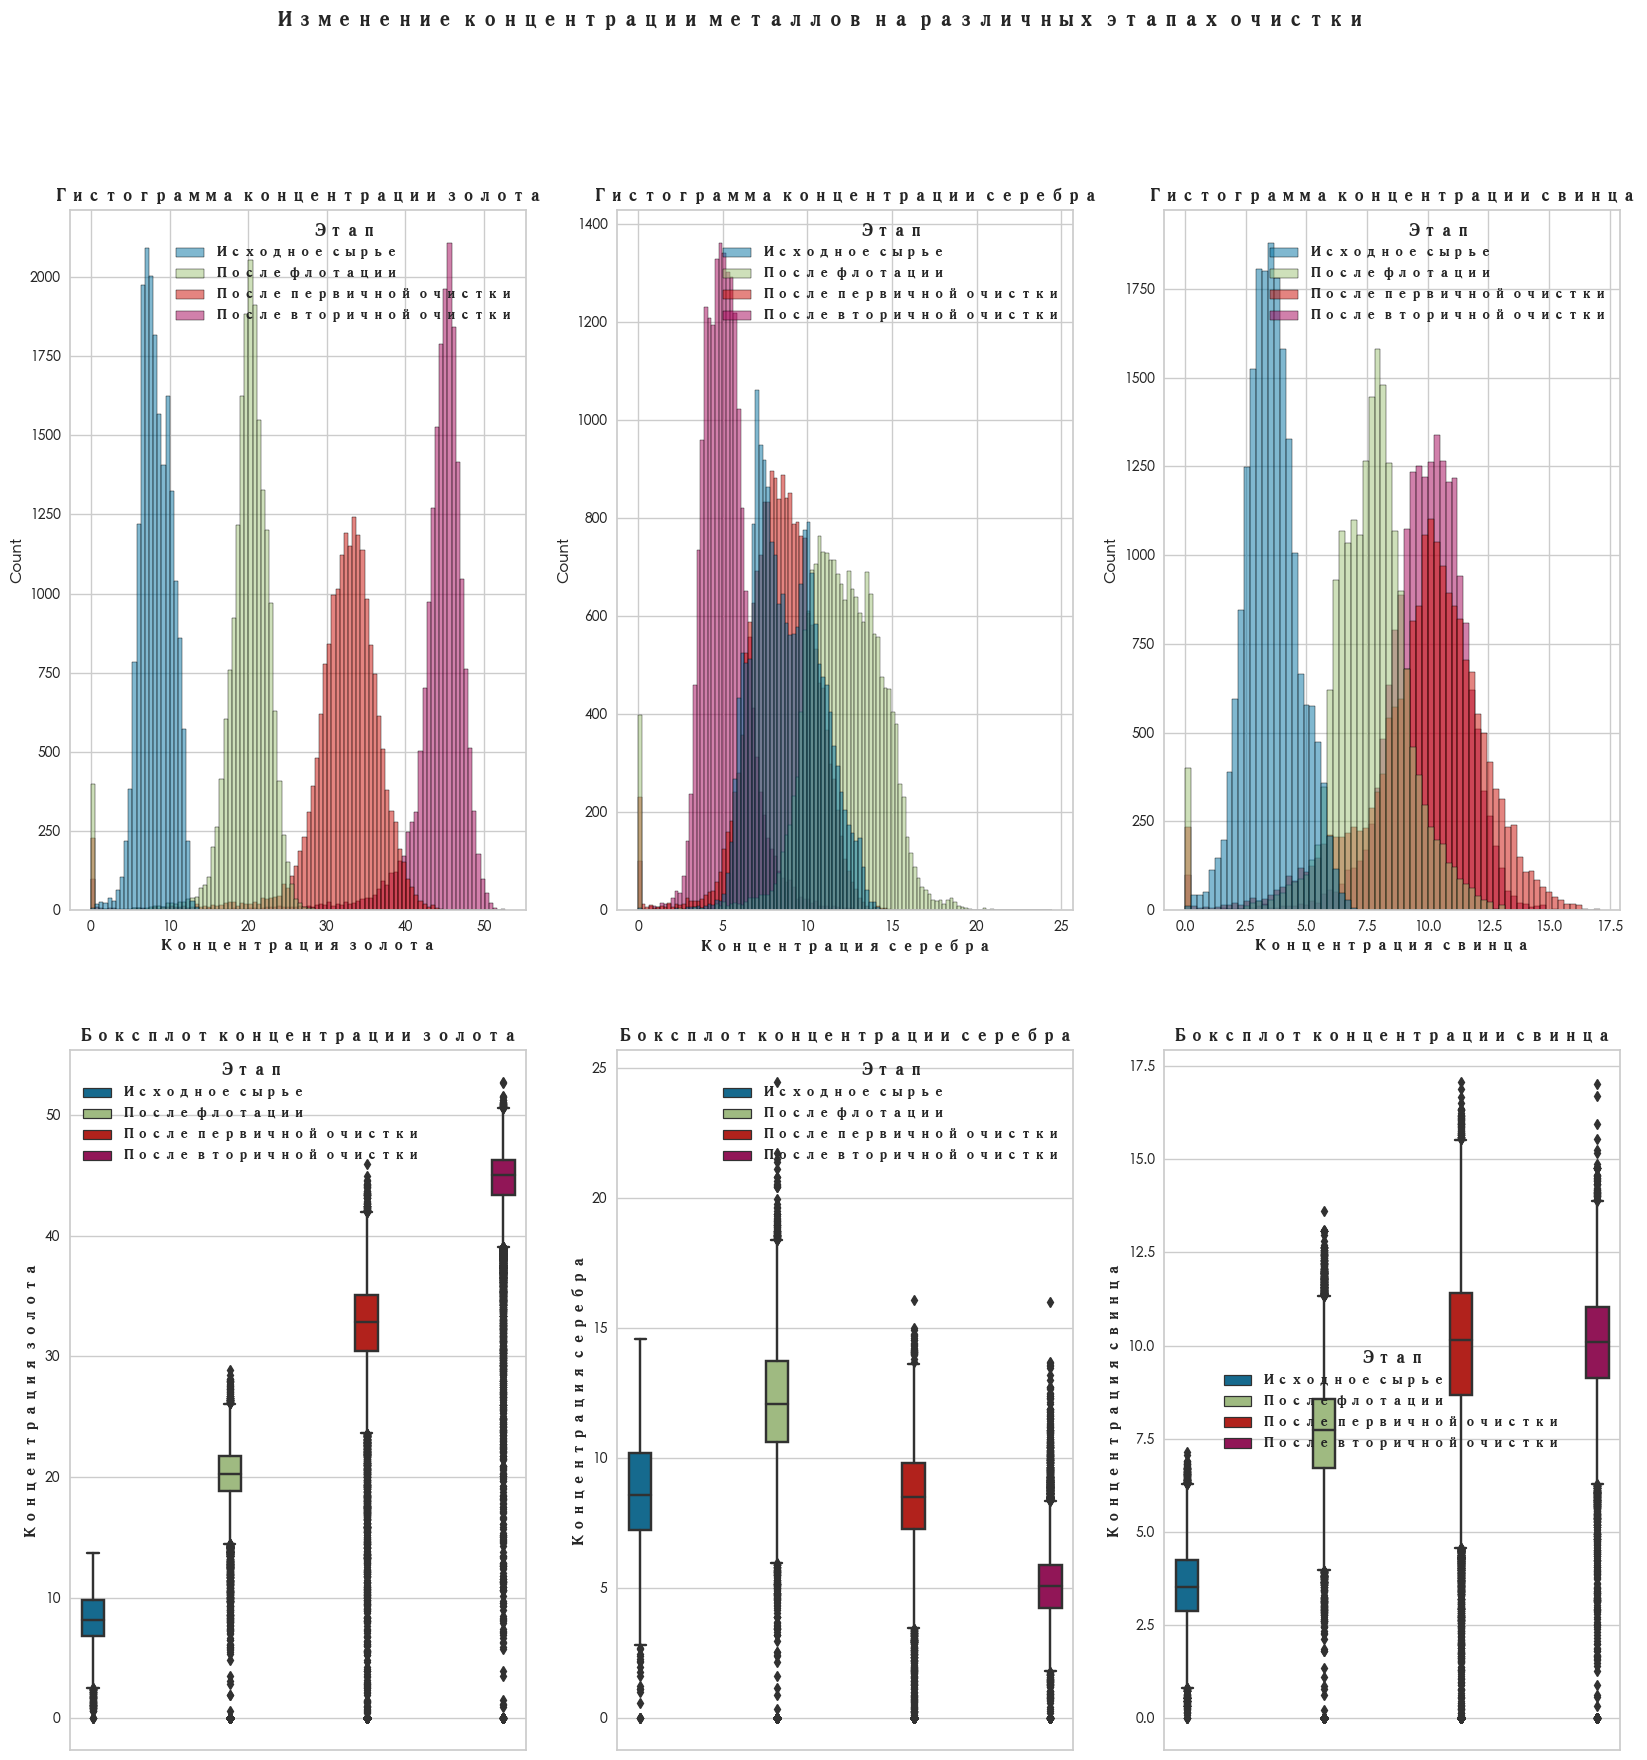

In [27]:
# создадим необходимые датафреймы / create required dfs
au = gold_recovery[['rougher.input.feed_au', 'rougher.output.concentrate_au',
                   'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]

ag = gold_recovery[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
                   'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]

pb = gold_recovery[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                   'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

# присвоим название колонок / assign column names
col_names = ['Исходное сырье', 'После флотации', 'После первичной очистки', 'После вторичной очистки']
au.columns = col_names
ag.columns = col_names
pb.columns = col_names

# применим функцию melt для подготовки данных для построения графиков
# apply melt function to prepare data for plotting
au = au.melt(var_name='Этап', value_name='Концентрация золота')
ag = ag.melt(var_name='Этап', value_name='Концентрация серебра')
pb = pb.melt(var_name='Этап', value_name='Концентрация свинца')

# настроим размер графика и его название / set plot size and its title
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
fig.suptitle('Изменение концентрации металлов на различных этапах очистки')


# гистограмма для золота / histogram for gold
sb.histplot(data=au,
            x='Концентрация золота',
            hue='Этап',
            ax=axes[0,0],
            bins = 100,
            alpha = 0.5)
axes[0,0].set_title('Гистограмма концентрации золота')

# боксплот для золота / boxplot for gold
sb.boxplot(data=au, x='Этап', y='Концентрация золота', hue='Этап', ax=axes[1,0])
axes[1,0].legend(fontsize='small', title='Этап')
axes[1,0].get_xaxis().set_visible(False)
axes[1,0].set_title('Боксплот концентрации золота')

# гистограмма для серебра / hist for silver
sb.histplot(data=ag,
            x='Концентрация серебра',
            hue='Этап',
            ax=axes[0,1],
            alpha = 0.5)
axes[0,1].set_title('Гистограмма концентрации серебра')

# боксплот для серебра / boxplot for silver
sb.boxplot(data=ag, x='Этап', y='Концентрация серебра', hue='Этап', ax=axes[1,1])
axes[1,1].legend(fontsize='small', title='Этап')
axes[1,1].get_xaxis().set_visible(False)
axes[1,1].set_title('Боксплот концентрации серебра')

#гистограмма для свинца / hist for lead
sb.histplot(data=pb,
            x='Концентрация свинца',
            alpha = 0.5,
            hue='Этап',
            ax=axes[0,2])
axes[0,2].set_title('Гистограмма концентрации свинца')

# боксплот для свинца / boxplot for lead
sb.boxplot(data=pb, x='Этап', y='Концентрация свинца', hue='Этап', ax=axes[1,2])
axes[1,2].legend(fontsize='small', title='Этап')
axes[1,2].set_title('Боксплот концентрации свинца')
axes[1,2].get_xaxis().set_visible(False);

Графики говорят о том, что средняя **концентрация золота** повышается в ходе очистки (видно на боксплоте),  средняя **концентрация серебра** - после флотации повышается, а при следующей очистке падает, а средняя **концентрация свинца** - резко повышается после флотации и первичной очистки и незначительно падает после вторичной очистки.

Исходя из этих наблюдений, можем сделать вывод, что концентрация целевого продукта, **золота**, растет постепенно с каждым этапом очистки, что есть хорошо. Мы увеличиваем содержание золота в единице продукта.

Также, при очистке золота мы избавляемся от побочных продуктов (в нашем случае, нас интересует только золото) - **серебра** и **свинца**. Технология очистки хорошо справляется с **серебром**, особенно на этапах первичной и вторичной очистки. А вот со **свинцом** технология очистки справялется хуже, его концентрация растет на всех этапах, кроме вторичной очистки.

Из гистограмм видно, что после каждого этапа очистки возникают нблюдения (400), где концентрация интересующих металлов очень низкая (0-0.1). В отношении золота, это плохая новость, но наблюдений не так уж и много (2.1%), они являются выбросами. К тому же, эти параметры отсутствуют в обучающей и тестовой выборках.
_____
The graphs show that the average **gold** concentration increases during refining (seen on the boxplot), the average **silver concentration** rises after flotation and drops during the next refining, and the average **lead concentration** - rises sharply after flotation and primary purification and drops slightly after secondary purification.

Based on these observations, we can conclude that the concentration of the target product, **gold**, increases gradually with each stage of purification, which is good. We are increasing the gold content per product unit.

Also, when refining gold, we get rid of by-products (in our case, we are only interested in gold) - **silver** and **lead**. The refining technology does a good job with **silver**, especially in the primary and secondary refining steps. But with **lead**, the purification technology copes worse, its concentration grows at all stages, except for secondary purification.

It can be seen from the histograms that after each purification step, observations (400) occur, where the concentration of the metals of interest is very low (0-0.1). For gold, this is bad news, but there are not that many observations (2.1%), they are outliers. In addition, these parameters are absent in the training and test samples.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках / Comparison of the size distribution of raw material granules on the training and test samples

Построим гистограммы.
____
Build histograms.

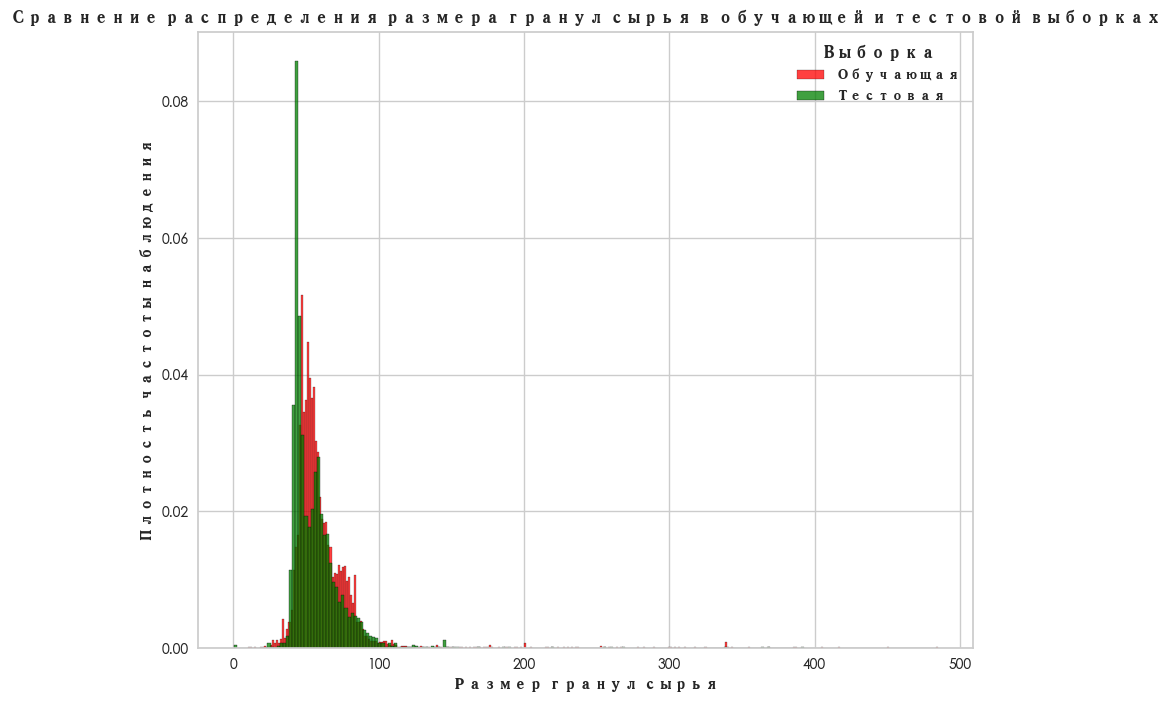

In [28]:
plt.figure(figsize=(10,8))
sb.histplot(data=gold_recovery_train['rougher.input.feed_size'], color='red', stat='density')
sb.histplot(data=gold_recovery_test['rougher.input.feed_size'], color='green', stat='density')
plt.legend(title='Выборка', labels=['Обучающая', 'Тестовая'])
plt.title('Сравнение распределения размера гранул сырья в обучающей и тестовой выборках')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Плотность частоты наблюдения');

Гистограммы распределения размеров гранул сырья значительно не отличаются между выборками. Оценка качества модели будет адекватной.

На гистограмме видно множество выбросов - слишком малых и слишком больших гранул. Изучим их подробнее.
_____

The distribution histograms of raw material granule sizes do not differ significantly between the samples. The evaluation of the quality of the model will be adequate.

The histogram shows a lot of outliers - too small and too large granules. Let's study them in more detail.

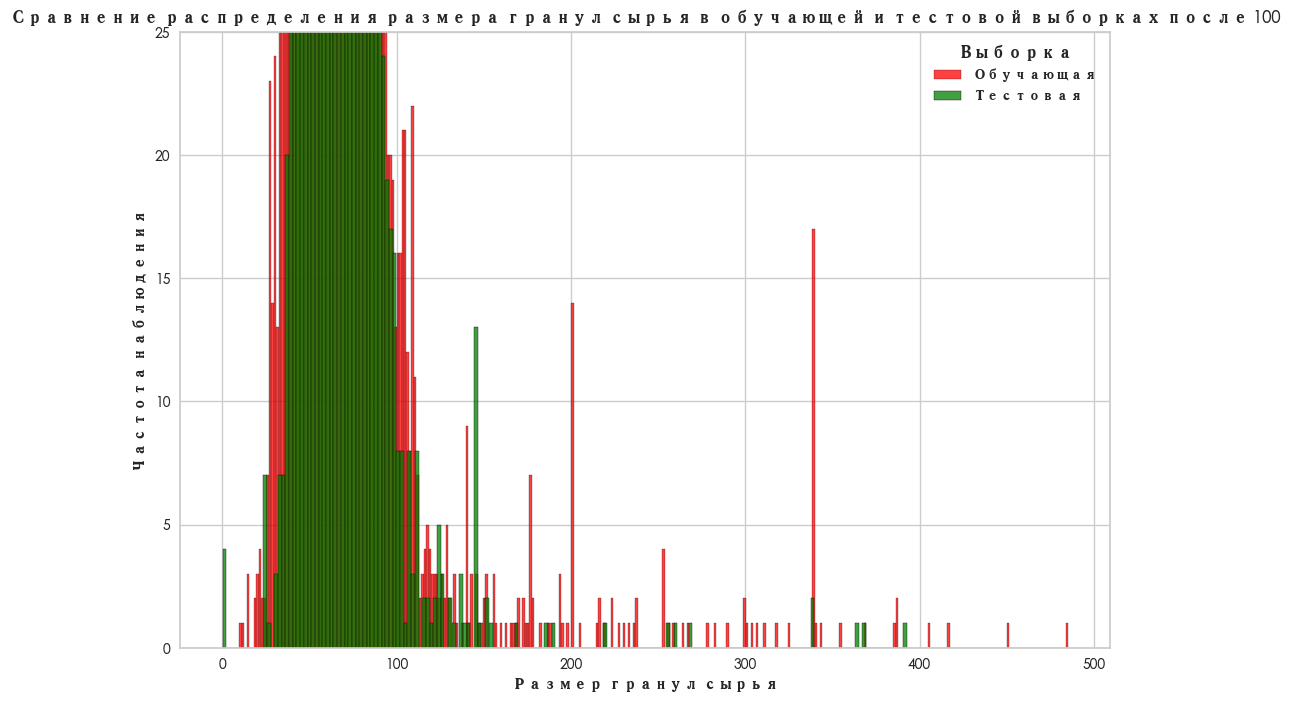

In [29]:
# гистограмма для выбросов после 100 / hist for outliers after 100
plt.figure(figsize=(12,8))
sb.histplot(data=gold_recovery_train['rougher.input.feed_size'], color='red')
sb.histplot(data=gold_recovery_test['rougher.input.feed_size'], color='green')
plt.legend(title='Выборка', labels=['Обучающая', 'Тестовая'])
plt.title('Сравнение распределения размера гранул сырья в обучающей и тестовой выборках после 100')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Частота наблюдения')
plt.ylim(0,25);

Видно, что наблюдения с размером гранул больше 120 можно удалить. Проверим какой это процент от всех наблюдений.
____
It can be seen that observations with a granule size greater than 120 can be removed. Let's check what is the percentage of all observations.

In [30]:
outliers_gr_120_train = len(gold_recovery_train[gold_recovery_train['rougher.input.feed_size'] > 120])
outliers_gr_120_test = len(gold_recovery_test[gold_recovery_test['rougher.input.feed_size'] > 120])

print('Количество наблюдений в тренировочной выборке с размером гранул больше 120:',
      outliers_gr_120_train,
      f'({round(outliers_gr_120_train / len(gold_recovery_train) * 100, 2)}%)')

print('Количество наблюдений в тестовой выборке с размером гранул больше 120:',
      outliers_gr_120_test,
      f'({round(outliers_gr_120_test / len(gold_recovery_test) * 100, 2)}%)')

Количество наблюдений в тренировочной выборке с размером гранул больше 120: 157 (1.11%)
Количество наблюдений в тестовой выборке с размером гранул больше 120: 47 (0.89%)


Всего лишь 1.11% и 0.89% соответственно, можем удалить выбросы больше 120 из обучающей и тренировочной выборок.
___
With only 1.11% and 0.89% respectively, we can remove outliers greater than 120 from the training and training samples.

In [31]:
# выбросим из выборок наблюдения с размером гранул больше 120
# remove observations with particle size above 120
gold_recovery_train = gold_recovery_train[gold_recovery_train['rougher.input.feed_size'] <= 120]
gold_recovery_test = gold_recovery_test[gold_recovery_test['rougher.input.feed_size'] <= 120]

# проверим / check
print(len(gold_recovery_train[gold_recovery_train['rougher.input.feed_size'] > 120]))
print(len(gold_recovery_test[gold_recovery_test['rougher.input.feed_size'] > 120]))

0
0


Теперь изучим подробнее выбросы с другой стороны.
____
Now let's study emissions from the other side in more detail.

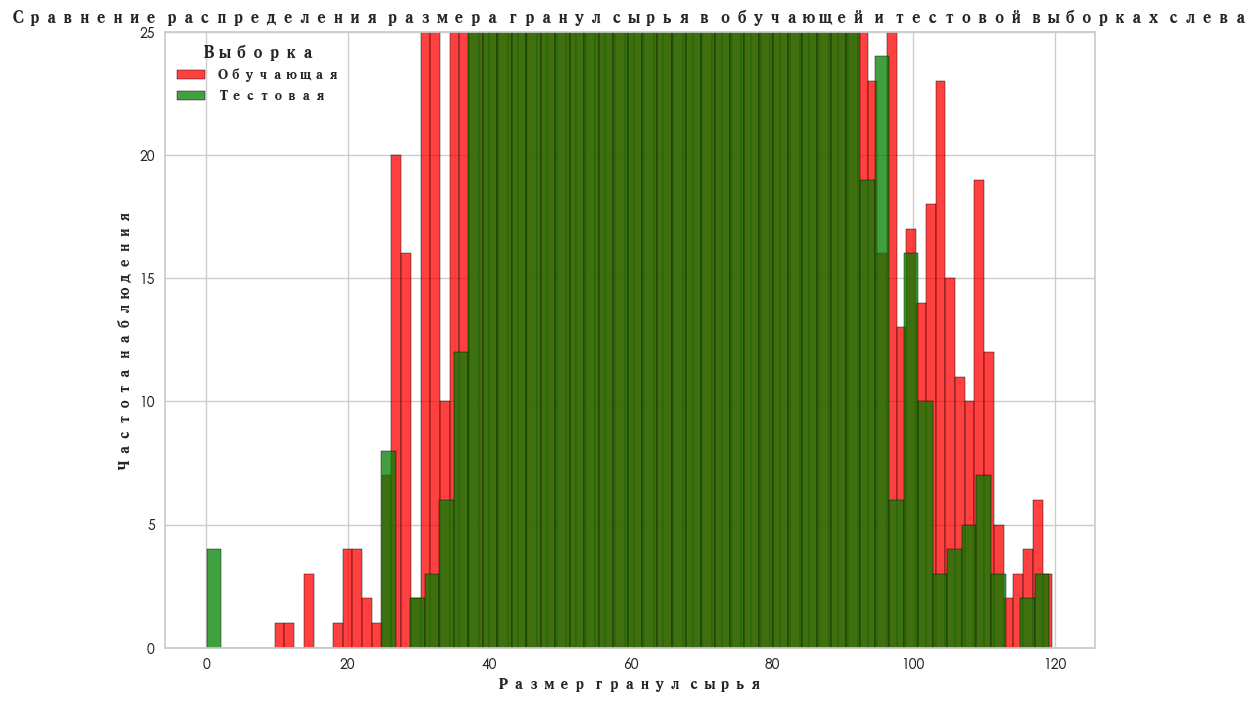

In [33]:
# гистограмма для выбросов слева
# histogram for outliers from left
plt.figure(figsize=(12,8))

sb.histplot(data=gold_recovery_train['rougher.input.feed_size'], color='red')
sb.histplot(data=gold_recovery_test['rougher.input.feed_size'], color='green')
plt.legend(title='Выборка', labels=['Обучающая', 'Тестовая'])
plt.title('Сравнение распределения размера гранул сырья в обучающей и тестовой выборках слева')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Частота наблюдения')
plt.ylim(0,25);

Виден одинокий столбец на 0 в тестовом датасете. Таких наблюдений меньше 5, поэтому, можно ничего с ними не делать.
____
A lone column at 0 is visible in the test dataset. There are less than 5 such observations, therefore, you can do nothing with them.

###  Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах / Study of the total concentration of all substances at different stages: in raw materials, in roughing and final concentrates

Проверим как меняется суммарная концентрация всех металлов (Au, Ag, Pb, Sol). Возьмем значения перед флотацией, после флотации, после первичной очистки, и после вторичной очистки.
____
Let's check how the total concentration of all metals (Au, Ag, Pb, Sol) changes. Let's take the values before flotation, after flotation, after primary cleaning, and after secondary cleaning.

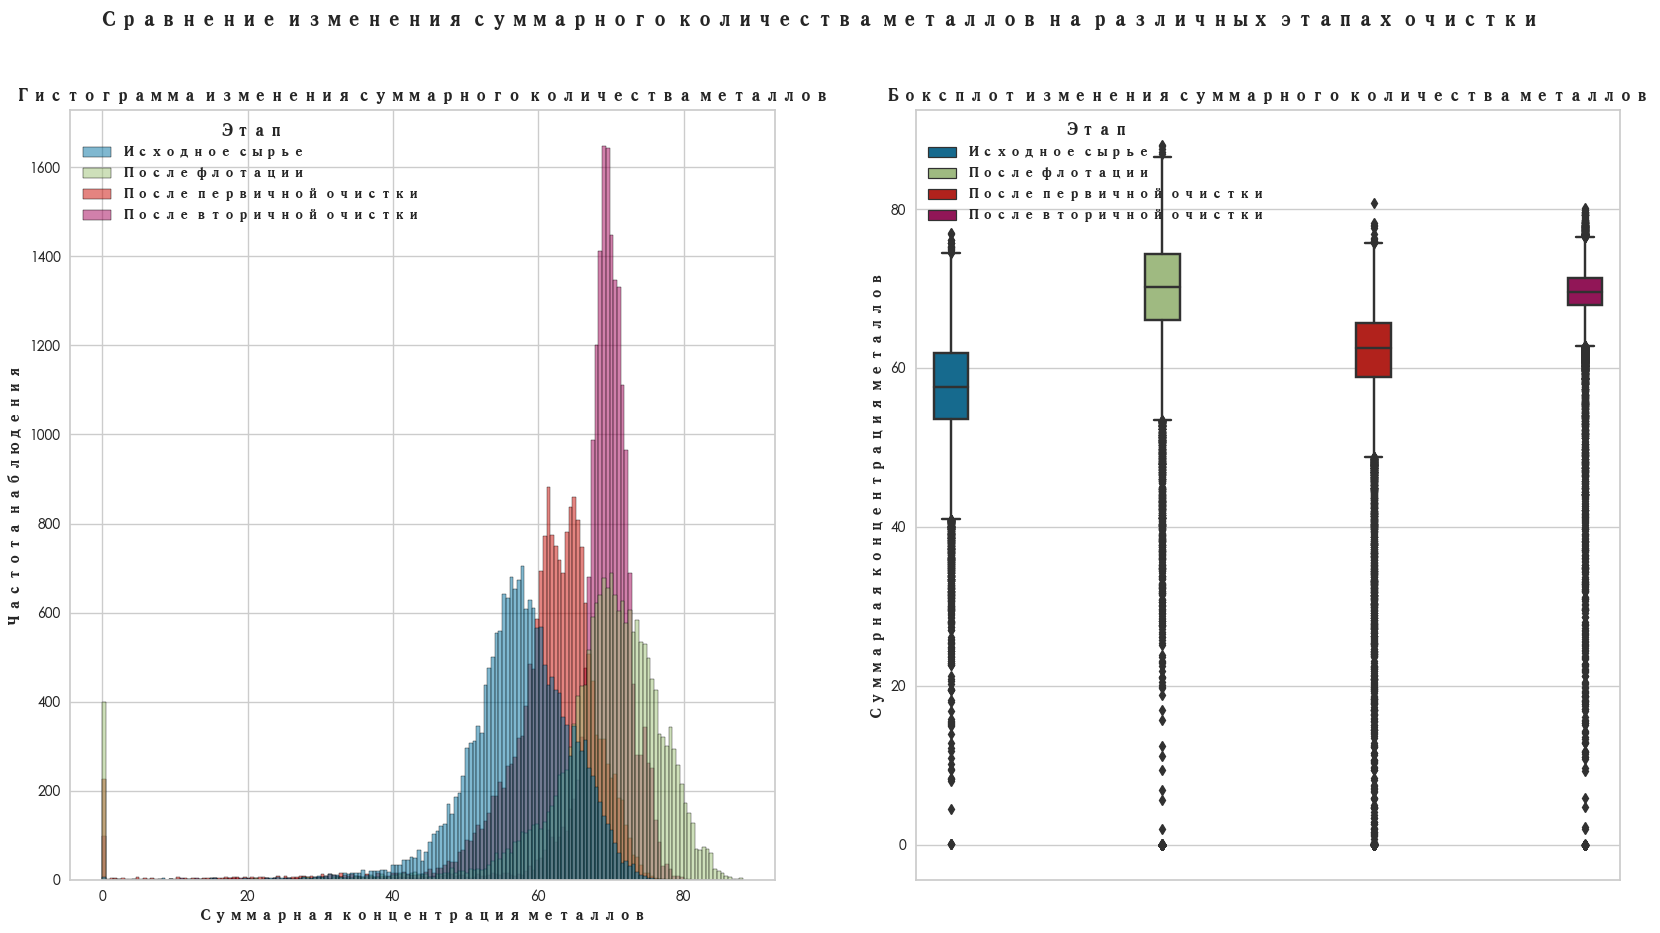

In [34]:
# создадим новый датафрейм с суммой металлов на каждой стадии и применим к нему метод melt()
# let's create new df with metal sum on each stage and apply melt() to it
me_change_sum = pd.DataFrame({
            'Before rougher': gold_recovery['rougher.input.feed_au'] +
              gold_recovery['rougher.input.feed_ag'] +
              gold_recovery['rougher.input.feed_pb'] + 
              gold_recovery['rougher.input.feed_sol'],
              
              'After rougher': gold_recovery['rougher.output.concentrate_au'] +
              gold_recovery['rougher.output.concentrate_ag'] +
              gold_recovery['rougher.output.concentrate_pb'] +
              gold_recovery['rougher.output.concentrate_sol']
              ,
              
              'After primary cleaner': gold_recovery['primary_cleaner.output.concentrate_au'] +
              gold_recovery['primary_cleaner.output.concentrate_ag'] +
              gold_recovery['primary_cleaner.output.concentrate_pb'] +
              gold_recovery['primary_cleaner.output.concentrate_sol'] 
              ,
              
              'Final concentration': gold_recovery['final.output.concentrate_au'] +
              gold_recovery['final.output.concentrate_ag'] +
              gold_recovery['final.output.concentrate_pb'] +
              gold_recovery['final.output.concentrate_sol']},
                            
                index=gold_recovery.index)

me_change_sum.columns = col_names
me_change_sum = me_change_sum.melt(var_name='Этап',
                                   value_name='Суммарная концентрация металлов',
                                   ignore_index=False)

fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Сравнение изменения суммарного количества металлов на различных этапах очистки')

sb.histplot(data=me_change_sum.reset_index(),
            x='Суммарная концентрация металлов',
            hue='Этап',
           ax=axes[0])
axes[0].set_title('Гистограмма изменения суммарного количества металлов')
axes[0].set_ylabel('Частота наблюдения')

sb.boxplot(data=me_change_sum.reset_index(),
           x='Этап',
           y='Суммарная концентрация металлов',
           hue='Этап',
           ax=axes[1])
axes[1].legend(fontsize='small', title='Этап')
axes[1].set_title('Боксплот изменения суммарного количества металлов')
axes[1].get_xaxis().set_visible(False);

График показывает, что у нас имеется около 400 наблюдений после флотации, около 200 наблюдений после первичной очистки, и около 100 наблюдений после вторичной очистки, у которых суммарная концентрация металлов находится около 0, либо равна 0.
____
The graph shows that we have about 400 observations after flotation, about 200 observations after primary cleaning, and about 100 observations after secondary cleaning, in which the total concentration of metals is about 0, or equal to 0.

In [35]:
# проверим сколько наблюдений имеют суммарную концентрацию металлов, равную 0
# check how many observations have sum of metal concentration = 0
len(me_change_sum[me_change_sum['Суммарная концентрация металлов'] == 0])

600

600 наблюдений в полной выборке. Удалим встречающиеся в тестовой и обучающей выборках. Нет смысла подавать в первичную обработку образцы-пустышки, так же как и во вторичную обработку. Получать в финальном продукте "ничего" также не соответствует целям бизнеса.
____
600 observations in the full sample. Let's delete those occurring in the test and training samples. It makes no sense to submit blank samples to primary processing, as well as to secondary processing. Getting "nothing" in the final product is also not in line with business goals.

Исследуем какие еще суммарные концентрации ближе к 0 попали в бин. Увеличим предыдущую гистограмму в районе нуля.
___
Let us examine what other total concentrations closer to 0 fell into the bin. Let's increase the previous histogram around zero.

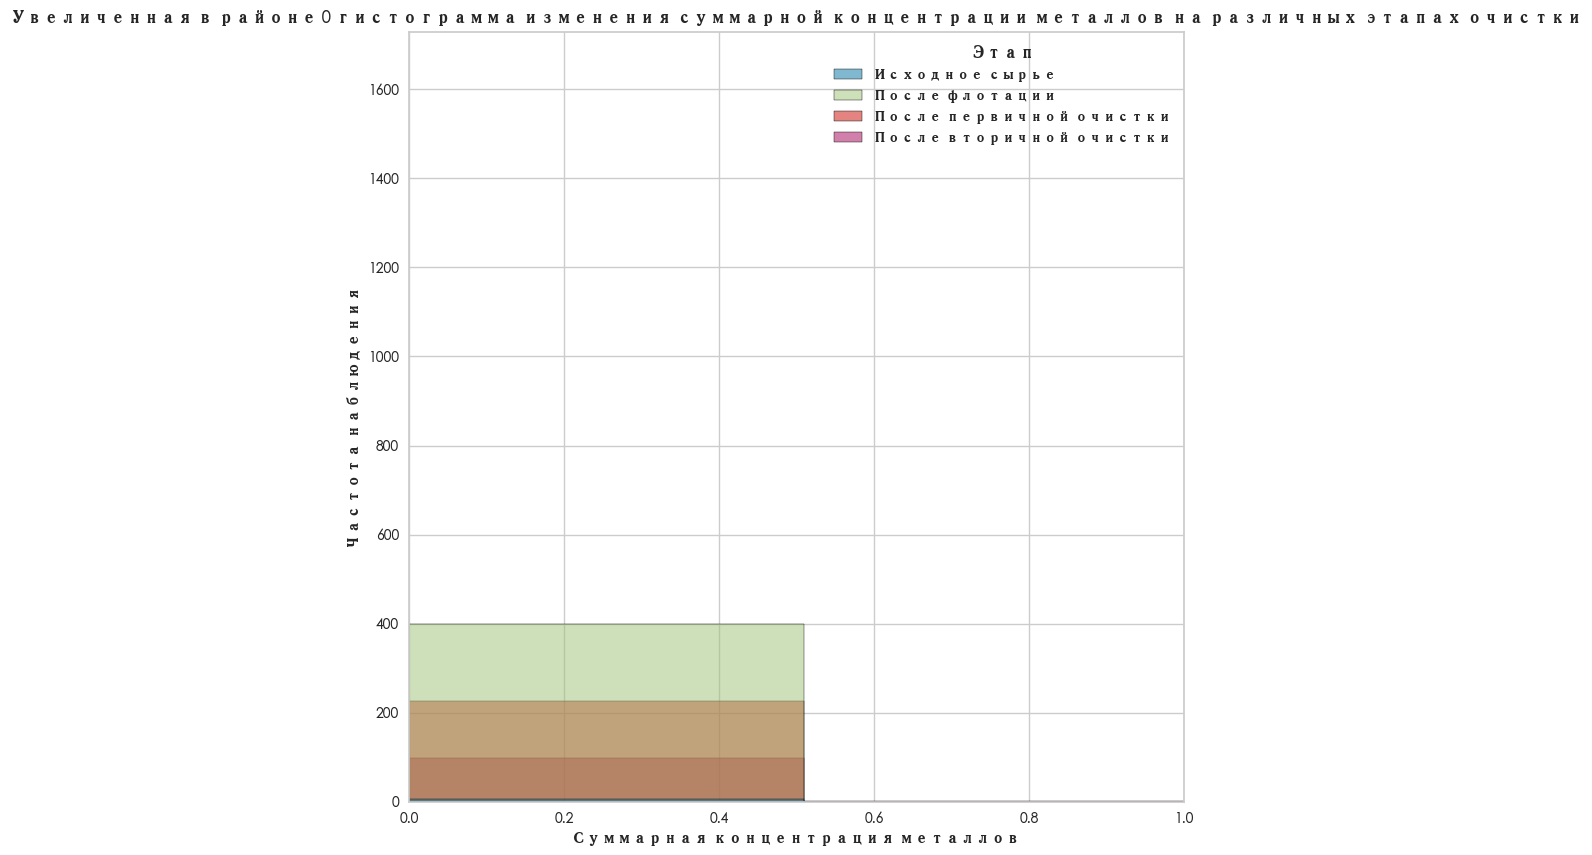

In [36]:
plt.figure(figsize=(10,10))
sb.histplot(data=me_change_sum.reset_index(),
            x='Суммарная концентрация металлов',
            hue='Этап')
plt.title('Увеличенная в районе 0 гистограмма изменения суммарной концентрации металлов на различных этапах очистки')
plt.ylabel('Частота наблюдения')
plt.xlim(0,1);

Из графика видно, что есть еще значения аномально отличающиеся от остальных. Они находятся в промежутке [0, 0.5]. Удалим эти наблюдения из тренировочного и тестового датасетов.
___
It can be seen from the graph that there are still values that are anomalously different from the rest. They are in the interval [0, 0.5]. Let's remove these observations from the training and test datasets.

In [37]:
# удалим наблюдения с суммарной нулевой концентрацией металлов по индексам
# delete observations with sum conc of metals by index
idx_to_delete = me_change_sum[me_change_sum['Суммарная концентрация металлов'] == 0].index

print('Размер выборок ДО удаления аномалий:', gold_recovery_train.shape, 'и', gold_recovery_test.shape)

gold_recovery_train.drop(idx_to_delete, axis=0, errors='ignore', inplace=True)
gold_recovery_test.drop(idx_to_delete, axis=0, errors='ignore', inplace=True)
print('Размер выборок ПОСЛЕ удаления аномалий:', gold_recovery_train.shape, 'и', gold_recovery_test.shape)

Размер выборок ДО удаления аномалий: (13992, 54) и (5243, 54)
Размер выборок ПОСЛЕ удаления аномалий: (13570, 54) и (5078, 54)


В сумме наши выборки содержали 587 нулевых суммарных концентраций металлов.
___
In total, our samples contained 587 zero total metal concentrations.

## Модель / Model

### Написание функции для вычисления итоговой sMAPE / Writing a function to calculate the final sMAPE

Напишем две функции: **final_smape()**. Первая будет рассчитывать метрику **sMAPE**, симметричное среднее абсолютное процентное отклонение, а вторая - итоговую метрику (**итоговое sMAPE**). Вторая будет принимать на вход результат исполнения первой.
____
Let's write two functions: **final_smape()**. The first one will calculate the **sMAPE** metric, the symmetrical mean absolute percentage deviation, and the second one will calculate the final metric (**final sMAPE**). The second will take as input the result of the execution of the first.

In [38]:
def smape(y_true, y_pred):
    '''
    Function takes target values
    and predictions.
    
    Function returns sMAPE metrics.
    
    Parameters:
    target (array like) - true values of target
    predict (array like) - predicted values of target
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2
    
    return (error / scale).mean() * 100

def final_smape(smape_rougher, smape_final):
    '''
    Function takes smape of values after
    rougher and values after secondary cleaner
    and calculates final sMAPE.
    
    Function returns final sMAPE metrics.
    
    Parameters:
    smape_rougher (float) - sMAPE on rougher recovery
    smape_final (float) - sMAPE on final recovery
    '''
    smape
    
    return ((0.25 * smape_rougher) + (0.75 * smape_final))

# сделаем функцию smape реактиной, чтобы передавать ее в стадию кросс-валидации
smape = make_scorer(smape, greater_is_better=False)

### Обучение и проверка моделей / Model training and evaluation

Прежде, чем обучать модели, необходимо разбить фичи и таргеты на отдельные переменные.
___
Before training models, it is necessary to break down features and targets into separate variables.

In [39]:
# фичи для тренировочного датасета
# train features
features_train = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

# таргеты для тренировочных датасетов
# targets for train
target_train_rougher = gold_recovery_train['rougher.output.recovery']
target_train_final = gold_recovery_train['final.output.recovery']

# фичи для тестового датасета
# test features
features_test = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

# таргеты для тестовых датасетов
# test targets
target_test_rougher = gold_recovery_test['rougher.output.recovery']
target_test_final = gold_recovery_test['final.output.recovery']

print('Размер тренировочных переменных:', features_train.shape)
print('Размер тестовых переменных', features_test.shape)
print('Размер тренировочных таргетов для флотации и вторичной очистки соответственно', target_train_rougher.shape,
     'и', target_train_final.shape)
print('Размер тестовых таргетов для флотации и вторичной очистки соответственно', target_test_rougher.shape,
     'и', target_test_final.shape)

Размер тренировочных переменных: (13570, 52)
Размер тестовых переменных (5078, 52)
Размер тренировочных таргетов для флотации и вторичной очистки соответственно (13570,) и (13570,)
Размер тестовых таргетов для флотации и вторичной очистки соответственно (5078,) и (5078,)


Разбили на переменные правильно.
___
Divided correctly.

#### Построение базовой модели линейной регрессии (БЛР) / Building a basic linear regression model (BLR)

In [40]:
# создадим модели
base_model_lr_rougher = LinearRegression()
base_model_lr_final = LinearRegression()

# проверим качество моделей кросс-валидацией (обучение моделей происходит во время кросс валидации)

# для rougher
base_cv_score_lr_rougher = cross_val_score(estimator=base_model_lr_rougher,
                                           X=features_train,
                                           y=target_train_rougher,
                                           scoring=smape).mean()
#для final
base_cv_score_lr_final = cross_val_score(estimator=base_model_lr_final,
                                         X=features_train,
                                         y=target_train_final,
                                         scoring=smape).mean()

# вычислим финальную sMAPE
base_lr_final_smape = final_smape(base_cv_score_lr_rougher,
                                 base_cv_score_lr_final)

print('sMAPE для rougher для базововой модели линейной регрессии:', round(base_cv_score_lr_rougher, 2))
print('sMAPE для final для базововой модели линейной регрессии:', round(base_cv_score_lr_final, 2))
print('Итоговое sMAPE для базовой модели линейной регрессии:', round(base_lr_final_smape, 2))

sMAPE для rougher для базововой модели линейной регрессии: -6.86
sMAPE для final для базововой модели линейной регрессии: -10.77
Итоговое sMAPE для базовой модели линейной регрессии: -9.79


Чтобы описать результаты проведения кросс-валидации, нам необходимо интуитивно понимать заданные ранее метрики (sMAPE и итоговое sMAPE).

**sMAPE** учитывает одновременно магнитуду параметров и ошибки. Наша **sMAPE** находится в пределах 0 до 200% (может быть от 0 до 100%, если не делить знаменатель на 2), что сложно для интерпретации её значения. Однако, если sMAPE имеет значения от -30% до +30%, [то её можно интерпретировать как **MAPE**](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc). А именно, какой средний процент отличия между целевыми значениями и нашими предсказаниями. Также, чем ниже sMAPE, [тем точнее наша модель](https://help.anaplan.com/685ff9b2-6370-46ba-af10-679405937113-Understand-advanced-metrics) (модель, не допускающая ошибок, имела бы sMAPE = 0).

**Итоговая sMAPE** - это просто совмещение информации, полученной на разных этапах: для расчета финального выхода продукта мы учитываем, сколько мы смогли очистить золота в ходе флотации и в ходе первичной и вторичной очисток. Так как эта метрика учитывает информацию метрики **sMAPE**, то идеальная модель будет иметь занчение **итоговой sMAPE**, равное 0.

Таким образом, результаты кросс-валидации **БЛР** показывают, что модель ошибается в среднем на 6.9% для значений выхода продукта после флотации, и на 10.8% для значений выхода финального продукта. Итоговая метрика равна 9.8%. Можно перефразировать так: ***Модель предсказывает выход финального продукта со средней погрешностью 9.8%***.

Хорошо это или плохо остается только гадать. За уточнениями по пороговому критерию отбора модели можно обратиться к бизнесу, они лучше знают свои цели и пороги рисков. Я бы процитировал Дятлова из мини-сериала HBO "Чернобыль": «Не отлично, но и не ужасно!». Теперь у нас есть базовая модель, с которой мы можем сравнивать наши последующие, оптимизированные.
____
To describe the results of cross-validation, we need to intuitively understand the previously set metrics (sMAPE and final sMAPE).

**sMAPE** considers parameter magnitude and error at the same time. Our **sMAPE** ranges from 0 to 200% (could be 0 to 100% if you don't divide the denominator by 2), which makes it difficult to interpret its meaning. However, if sMAPE has values between -30% and +30% [then it can be interpreted as **MAPE**](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc). Namely, what is the average percentage difference between the target values and our predictions. Also, the lower the sMAPE, [the more accurate our model](https://help.anaplan.com/685ff9b2-6370-46ba-af10-679405937113-Understand-advanced-metrics) (an error free model would have sMAPE = 0).

**Final sMAPE** is simply a combination of information obtained at different stages: to calculate the final yield of the product, we take into account how much gold we were able to refine during flotation and during primary and secondary refining. Since this metric takes into account the **sMAPE** metric information, the ideal model would have a **final sMAPE** value of 0.

Thus, the results of the **BLR** cross-validation show that the model is wrong on average by 6.9% for the values of the product after flotation, and by 10.8% for the values of the final product. The final metric is 9.8%. It can be rephrased as follows: ***The model predicts the yield of the final product with an average error of 9.8%***.

Whether this is good or bad is anyone's guess. For clarifications on the threshold criterion for selecting a model, you can contact the business, they know their goals and risk thresholds better. I would quote Dyatlov from the HBO mini-series Chernobyl: “Not great, but not terrible either!” We now have a base model against which we can compare our subsequent, optimized ones.

Какие дальнейшие шаги можно предпринять, чтобы улучшить модель? Например, можно убрать мультиколлинеарность из данных, т.е. убрать признаки, которые очень сильно коррелируют с другими. Также, можно обучать модель не на всех фичах, а выбрать подмножество признаков, которые вносят весомый вклад в предсказание целевого признака. Мы можем объединить эти два этапа в одно обучение - используем **LASSO-регрессию**. Она ингорирует мультиколлинеарность в данных, а также сводит коэффициенты регрессии некоторых признаков к 0, таким образом, проводя отбор признаков.
____
What further steps can be taken to improve the model? For example, you can remove multicollinearity from the data, i.e. remove features that are highly correlated with others. Also, you can train the model not on all features, but select a subset of features that make a significant contribution to the prediction of the target feature. We can combine these two steps into one training using **LASSO regression**. It incorporates multicollinearity in the data and also reduces the regression coefficients of some features to 0, thus performing feature selection.

#### LASSO-regression

LASSO-регрессия, в отличии от простой, имеет параметр **alpha** (параметр регуляризации), который необходимо оптимизировать. Для этой цели используем GridSearch(), который будет перебирать все заданные нами параметры, чтобы найти тот, который дает лучший показатель заданной метрики (sMAPE) путем кросс-валидации.
___
LASSO regression, unlike simple regression, has an **alpha** parameter (regularization parameter) that needs to be optimized. For this purpose, we use GridSearch(), which will iterate through all the parameters we set to find the one that gives the best score for the given metric (sMAPE) through cross-validation.

In [41]:
# создадим лист со значениями alpha для перебора
alpha_grid = {'alpha': np.logspace(-2, 2, 50)}

# создадим модели LASSO
lasso_rougher = Lasso()
lasso_final = Lasso()

# создадим объекты для перебора параметра alpha
lasso_reg_rougher = GridSearchCV(lasso_rougher,
                                alpha_grid,
                                scoring=smape)

lasso_reg_final = GridSearchCV(lasso_final,
                                alpha_grid,
                                scoring=smape)

# обучим модели
lasso_reg_rougher.fit(features_train, target_train_rougher)
lasso_reg_final.fit(features_train, target_train_final)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e+03, tolerance: 6.430e+01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e+03, tolerance: 6.430e+01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.522e+02, tolerance: 6.430e+01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_co

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01, 2.94705170e-01, 3.55648...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])},
             scoring=make_scorer(smape, greater_is_better=False))

In [42]:
print('Оптимизированное значение alpha для rougher:', round(lasso_reg_rougher.best_params_['alpha'], 2))
print('Оптимизированное значение alpha для final:', round(lasso_reg_final.best_params_['alpha'], 2))
print()
print('Лучшее sMAPE для rougher для LASSO:', round(lasso_reg_rougher.best_score_, 2))
print('Лучшее sMAPE для final для LASSO:', round(lasso_reg_final.best_score_, 2))
print()
print('Итоговое sMAPE для LASSO:', round(final_smape(lasso_reg_rougher.best_score_,
                                                    lasso_reg_final.best_score_), 2))

Оптимизированное значение alpha для rougher: 0.29
Оптимизированное значение alpha для final: 47.15

Лучшее sMAPE для rougher для LASSO: -6.18
Лучшее sMAPE для final для LASSO: -9.7

Итоговое sMAPE для LASSO: -8.82


На минусы в значениях метрик можно не обращать внимание. Это все из-за параметра greater_is_better=False при создании функций метрик.
____
You can ignore the minuses in the values of the metrics. This is all because of the greater_is_better=False parameter when creating metrics functions

Всегда интересно посмотреть на графики изменения метрики в зависимости от изменения настариваемого параметра. С помощью библиотеки **yellowbrick** построим два графика оптимизации гиперпараметра alpha: один для rougher, второй - для final.
___
It is always interesting to look at the graphs of metric changes depending on the change in the parameter being adjusted. Using the **yellowbrick** library, we will build two hyperparameter alpha optimization graphs: one for rougher, the second for final.

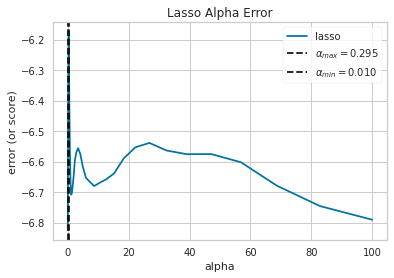

<AxesSubplot:title={'center':'Lasso Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [35]:
# создадим объект визуализации, содержащий параметры нашей кросс-валидации
visualizer = ManualAlphaSelection(
    Lasso(random_state=1),
    alphas=alpha_grid['alpha'],
    cv=5,
    scoring=smape)

# обучим созданный объект на данных rougher
visualizer.fit(features_train, target_train_rougher)

visualizer.show()

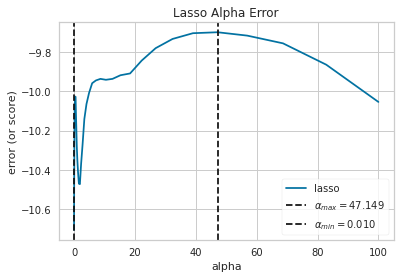

<AxesSubplot:title={'center':'Lasso Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [36]:
# создадим объект визуализации, содержащий параметры нашей кросс-валидации
visualizer = ManualAlphaSelection(
    Lasso(random_state=1),
    alphas=alpha_grid['alpha'],
    cv=5,
    scoring=smape)

# обучим созданный объект на данных final
visualizer.fit(features_train, target_train_final)

visualizer.show()

Графики отображают, то что мы получили, используя GridSearch(). Так как мы не учитываем отрицательный знак в значениях метрики, график необходимо интерпретировать без них. То есть нас интересует значение alpha_max. Это то значение alpha, при котором наша метрика минимальна.
___
The graphs show what we got using GridSearch(). Since we do not take into account the negative sign in the metric values, the graph must be interpreted without them. That is, we are interested in the value of alpha_max. This is the alpha value at which our metric is minimal.

In [43]:
# посмотрим на коэффициенты для параметров в лассо-регресии
print('Коэффициенты регрессии для LASSO для rougher данных:')
print()
print(list(lasso_reg_rougher.best_estimator_.coef_))
print()
print('Из них количество значимых:',
      len(lasso_reg_rougher.best_estimator_.coef_[lasso_reg_rougher.best_estimator_.coef_ != 0]))
print()
print('Коэффициенты регрессии для LASSO для final данных:')
print()
print(list(lasso_reg_final.best_estimator_.coef_))
print()
print('Из них количество значимых:',
      len(lasso_reg_final.best_estimator_.coef_[lasso_reg_final.best_estimator_.coef_ != 0]))

Коэффициенты регрессии для LASSO для rougher данных:

[0.0598999450144683, -0.0, 0.0, -0.0, -0.00121044638477602, 0.0, 0.007696624790882039, -0.0, -0.0005058297594268196, 0.007467403173946137, -0.004251249372562215, -0.0, 0.34961107778484446, 0.0, -0.01691386553181336, 0.05312583456554136, 0.3350034845461823, 0.3108198335596367, -0.37246958984089645, 0.7791605342472239, -0.02266659364402065, 0.0, -0.004591966311367616, 0.01731443893395404, -0.0024871605653884535, 0.014138911618060525, -0.0033825503767608953, -0.0052993735271195525, -0.004843114996347353, 0.0, -0.008520758457843622, -0.003974444734112834, 0.016142684220587893, -0.007671586725095683, 0.05894562789552772, 0.0079745861755707, -0.0, -0.015623697489944386, 0.16887773615588755, -0.013182999721122059, -0.18959693061320423, 0.009873241599001915, 0.0, 0.0048887141559624215, 0.0, 0.00633338834047412, 0.1516103423275558, -0.0025785736244326556, -0.0, 0.025100208074613127, -0.12726822011999048, -0.020721214288738292]

Из них количе

Большинство коэффициентов для переменных в предсказании конечного (final) выхода продукта были сведены к 0. Это значит, что они не важны для предсказания и мы можем испоьзовать для этой цели только переменные с ненулевыми коэффициентами.

Для предсказания же выхода продукта после флотации важны почти все переменные, за исключением некоторых.

Теперь необходимо обучить наши модели еще раз, используя оптимизированные значения **alpha** и используя в тренировочных данных только важные фичи (по результатам лассо-регрессии).
____
Most of the coefficients for the variables in the prediction of the final product yield have been reduced to 0. This means that they are not important for the prediction and we can only use variables with non-zero coefficients for this purpose.

To predict the yield of the product after flotation, almost all variables are important, with the exception of a few.

Now we need to train our models again using the optimized **alpha** values and using only the important features in the training data (based on the results of lasso regression).

In [44]:
# отберем необходимые фичи
features_train_rougher_lasso = features_train[features_train.columns[lasso_reg_rougher.best_estimator_.coef_ != 0]]
features_train_final_lasso = features_train[features_train.columns[lasso_reg_final.best_estimator_.coef_ != 0]]

print(features_train_rougher_lasso.shape)
print(features_train_final_lasso.shape)

(13570, 39)
(13570, 7)


In [45]:
# проведем обучение новых моделей LASSO и их кросс-валидацию

lasso_opt_rougher = Lasso(alpha=lasso_reg_rougher.best_params_['alpha'])
lasso_opt_final = Lasso(alpha=lasso_reg_final.best_params_['alpha'])

opt_lasso_cv_score_rougher = cross_val_score(estimator=lasso_opt_rougher,
                                         X=features_train_rougher_lasso,
                                         y=target_train_rougher,
                                         scoring=smape).mean()

opt_lasso_cv_score_final = cross_val_score(estimator=lasso_opt_final,
                                         X=features_train_final_lasso,
                                         y=target_train_final,
                                         scoring=smape).mean()

print('sMAPE для rougher для оптимизированной LASSO-регрессии:', round(opt_lasso_cv_score_rougher, 2))
print('sMAPE для final для оптимизированной LASSO-регрессии:', round(opt_lasso_cv_score_final, 2))
print('Итоговое sMAPE для базовой модели линейной регрессии:', round(final_smape(opt_lasso_cv_score_rougher,
                                                                                opt_lasso_cv_score_final), 2))

sMAPE для rougher для оптимизированной LASSO-регрессии: -6.05
sMAPE для final для оптимизированной LASSO-регрессии: -9.54
Итоговое sMAPE для базовой модели линейной регрессии: -8.67


Мы уже ошибаемся не на 9.7%, а на 8.67%. Улучшили модель с помощью лассо регуляризации.
___
We are already wrong not by 9.7%, but by 8.67%. Improved the model using lasso regularization.

#### RandomForestRegressor (RFR)

По моему скромному опыту знаю, что регрессионный случайный лес может выдавать отличные результаты даже без настройки гиперпараметров. Проверим как наши данные опишет такая модель.
___
In my humble experience, I know that Random Regression Forest can produce great results even without hyperparameter tuning. Let's check how our data will be described by such a model.

In [47]:
# создадим базовые модели RFR
base_rfr_rougher = RandomForestRegressor()
base_rfr_final = RandomForestRegressor()

# проверим качество моделей кросс-валидацией (обучение моделей происходит во время кросс валидации)

# для rougher
base_cv_score_rfr_rougher = cross_val_score(estimator=base_rfr_rougher,
                                           X=features_train,
                                           y=target_train_rougher,
                                           scoring=smape).mean()
#для final
base_cv_score_rfr_final = cross_val_score(estimator=base_rfr_final,
                                         X=features_train,
                                         y=target_train_final,
                                         scoring=smape).mean()

# вычислим финальную sMAPE
base_rfr_final_smape = final_smape(base_cv_score_rfr_rougher,
                                 base_cv_score_rfr_final)

print('sMAPE для rougher для базововой модели RFR:', round(base_cv_score_rfr_rougher, 2))
print('sMAPE для final для базововой модели RFR:', round(base_cv_score_rfr_final, 2))
print('Итоговое sMAPE для базовой модели RFR:', round(base_rfr_final_smape, 2))

sMAPE для rougher для базововой модели RFR: -6.66
sMAPE для final для базововой модели RFR: -9.66
Итоговое sMAPE для базовой модели RFR: -8.91


Базовая модель RFR выдала результат лучше, чем БЛР, но хуже, чем LASSO-регрессия. Если RFR оптимизировать, результаты могут улучшиться значительно. GridSearch() будет работать очень долго, поэтому используем RandomizedSearch().
____
The base RFR model performed better than BLR but worse than LASSO regression. If the RFR is optimized, the results can improve significantly. GridSearch() will take a very long time, so we use RandomizedSearch().

In [48]:
# создадим сетку параметров
random_grid = {'n_estimators': [n for n in range(200, 610, 10)],
               'max_depth': [depth for depth in range(10, 100, 10)]}

# зададим параметры поиска лучшей модели для rougher
rfr_random_rougher = RandomizedSearchCV(estimator=base_rfr_rougher,
                                       param_distributions=random_grid,
                                       random_state=42,
                                       scoring=smape,
                                       n_jobs=-1)

# зададим параметры поиска лучшей модели для final
rfr_random_final = RandomizedSearchCV(estimator=base_rfr_final,
                                       param_distributions=random_grid,
                                       random_state=42,
                                       scoring=smape,
                                       n_jobs=-1)

# обучим модели
rfr_random_rougher.fit(features_train, target_train_rougher)
rfr_random_final.fit(features_train, target_train_final)

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Executing shutdown due to inactivity...


2023-01-26 11:14:31,811 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2023-01-26 11:14:31,824 - INFO     - Executing shutdown...
/Users/vlad/.local/lib/python3.9/site-packages/dtale/app.py:422: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90],
                                        'n_estimators': [200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, 310,
                                                         320, 330, 340, 350,
                                                         360, 370, 380, 390,
                                                         400, 410, 420, 430,
                                                         440, 450, 460, 470,
                                                         480, 490, ...]},
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [49]:
print('Оптимизированное значение n_estimators и max_depth для rougher:',
      rfr_random_rougher.best_params_['n_estimators'],
     'и', rfr_random_rougher.best_params_['max_depth'])

print('Оптимизированное значение n_estimators и max_depth для final:',
      rfr_random_final.best_params_['n_estimators'],
     'и', rfr_random_final.best_params_['max_depth'])
print()
print('Лучшее sMAPE для rougher для оптимизированного RFR:', round(rfr_random_rougher.best_score_, 2))
print('Лучшее sMAPE для final для оптимизированного RFR:', round(rfr_random_final.best_score_, 2))
print()
print('Итоговое sMAPE для оптимизированного RFR:', round(final_smape(rfr_random_rougher.best_score_,
                                                    rfr_random_final.best_score_), 2))

Оптимизированное значение n_estimators и max_depth для rougher: 530 и 10
Оптимизированное значение n_estimators и max_depth для final: 530 и 10

Лучшее sMAPE для rougher для оптимизированного RFR: -6.4
Лучшее sMAPE для final для оптимизированного RFR: -9.5

Итоговое sMAPE для оптимизированного RFR: -8.73


Получили результат идентичный результату после лассо-регрессии. Мы оптимизировали только два параметра. Если бы оптимизировали больше значений и больше параметров, возможно, наша модель улучшилась еще больше. Выберем для тестирования модель лассо-регрессии с оптимизированными значениями alpha и отобранными признаками.
___
We got the result identical to the result after lasso regression. We have only optimized two parameters. If more values and more parameters were optimized, perhaps our model would improve even more. We choose for testing a lasso regression model with optimized alpha values and selected features.

### Проверка итоговой модели на тестовой выборке / Checking the final model on a test set

Проверим лучшую модель на тестовой выборке и посмотрим как она работает с данными, которые она никогда не видела. Таким образом, мы имитируем ситуацию, когда мы будем применять нашу модель на производстве по добыче золота, чтобы оптимизировать его и не запускать убыточные проекты.
___
Let's test the best model on a test set and see how it performs with data that it has never seen before. Thus, we simulate a situation where we will apply our model to a gold mining operation in order to optimize it and not launch unprofitable projects.

In [50]:
# отберем необходимые фичи из тестового набора
features_test_rougher_lasso = features_test[features_test.columns[lasso_reg_rougher.best_estimator_.coef_ != 0]]
features_test_final_lasso = features_test[features_test.columns[lasso_reg_final.best_estimator_.coef_ != 0]]

# проверим размер тестовых выборок
print(features_test_rougher_lasso.shape)
print(features_test_final_lasso.shape)

(5078, 39)
(5078, 7)


In [51]:
# обучим модели
lasso_opt_rougher.fit(features_train_rougher_lasso, target_train_rougher)
lasso_opt_final.fit(features_train_final_lasso, target_train_final)

# сделаем предсказания
lasso_opt_rougher_pred = lasso_opt_rougher.predict(features_test_rougher_lasso)
lasso_opt_final_pred = lasso_opt_final.predict(features_test_final_lasso)

In [52]:
# надо будет создать функцию smape  еще раз так как мы делали ее callable  с помощью make_scorer()
def smape(y_true, y_pred):
    '''
    Function takes target values
    and predictions.
    
    Function returns sMAPE metrics.
    
    Parameters:
    target (array like) - true values of target
    predict (array like) - predicted values of target
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2
    
    return (error / scale).mean() * 100

In [53]:
# посчитаем метрики
test_smape_rougher = smape(lasso_opt_rougher_pred, target_test_rougher)
test_smape_final = smape(lasso_opt_final_pred, target_test_final)

final_test_smape = final_smape(test_smape_rougher, test_smape_final)

print('sMAPE на тестовой выборке для rougher:', round(test_smape_rougher, 2))
print('sMAPE на тестовой выборке для final:', round(test_smape_final, 2))

print('Итоговая sMAPE на тестовой выборке:', round(final_test_smape, 2))

sMAPE на тестовой выборке для rougher: 4.95
sMAPE на тестовой выборке для final: 7.51
Итоговая sMAPE на тестовой выборке: 6.87


Значения метрик на тестовой выборке еще лучше, чем при кросс-валидации. Это хороший знак. Выбираем эту модель как финальную.
___
The values of the metrics on the test set are even better than in cross-validation. This is a good sign. We choose this model as the final one.

## Общий вывод / Final report

В данном проекте мы создавали прототип модели машинного обучения для предсказания кэффициента восстановления золота из золотосодержащей руды. Проект был разделен на 3 части:

**1) Изучение и подготовка данных**

На данном этапе мы провели первичное ознакомление с данными, посмотрели на их размер и типы данных. Далее мы проверили правильно ли рассчитана эффективность добычи золота. МАЕ между табличными и рассчитанными нами значениями составила **9.74 x 10<sup>-15</sup>**. Сделали вывод, что эффективность рассчитана правильно. После этого мы сравнили признаки, доступные в тренировочном и тестовом датасетах, а также провели предобработку. Она включала удаление из обучающих данных колонок, которые отсутствуют в тестовом датасете, и заполнение пропусков. Рациональным способом заполнения пропусков посчитали заполнение средним двух соседних значений. Обосновывали такое решение тем, что наши данные индексируются датой-временем и соседние значения часто могут быть похожи. Также, на этом этапе добавили в тестовую выборку целевые переменные - rougher.output.recovery и final.output.recovery.

**2) Анализ данных**

Данны этап включал ИАД - проверили корреляции между целевыми и остальными переменными, а также между признаками. Целевые переменные не имели сильных корреляций с признаками, а между признаками были все виды корреляций (от очень сильных до очень слабых).Таким образом, мы определили **мультиколлинеарность** в данных. Также мы изучили как концентрация различных металлов меняется на разных этапах очистки - построили гистограммы и боксплоты. Концентрация золота повышается, а концентрация остальных металлов падает в ходе очистки. Еще одной задачей в ИАД было сравнить распределения размеров гранул сырья в тренирововчном и тестовом наборах. После сравнения сделали вывод, что распределения не отличаются. Выкинули выбросы размеров гранул сырья. На последнем этапе ИАД исследовали суммарные концентрации металлов на различных этапах очистки. Нашли аномалии (нулевые и очень малые суммарные концентрации металлов), удалили их.

**3) Построение и проверка моделей**

Написали функции для расчета интересующих метрик - sMAPE и итоговая sMAPE. Сначала построили базовую модель линейной регрессии, итоговая метрика составили 9.7%. Затем применили LASSO-регрессию, чтобы учесть мультиколлинеарность в данных и отобрать значимые признаки. Финальная метрика составила 8.67%. Далее обучили регрессионный случайный лес (без оптимизации гиперпараметров). Такая модель выдала метрику после кросс-валидации, равную 8.99%. Оптимизация гиперпараметров **n_estimators** и **max_depth** не показали улучшения метрики. На тестовой выборке проверили модель лассо-регрессии с параметрами alpha = 0.29 (rougher) и 47.15 (final) и количеством признаков 39 (rougher) и 7 (final). Значения sMAPE составили 4.95 (rougher) и 7.51 (final), а итоговая sMAPE - 6.87, что ниже, чем при кросс-валидации. Это значит, что наша модель смогла найти закономерности в данных и описать их в данных, которые она никогда не видела.

В качестве финальной модели выбрали линейную регрессию с LASSO-регуляризацией (параметр alpha = 0.29 для rougher и 47.15 для final). Для обучения модели предсказания коэффициента восстановления золота после флотации можно использовать 39 признаков вместо 52, для предсказания финального продукта - всего лишь 7 из 52.
_____
In this project, we created a prototype machine learning model to predict the recovery rate of gold from gold ore. The project was divided into 3 parts:

**1) Research and preparation of data**

At this stage, we conducted an initial acquaintance with the data, looked at their size and data types. Next, we checked whether the efficiency of gold mining was calculated correctly. MAU between the tabulated and calculated values was **9.74 x 10<sup>-15</sup>**. We concluded that the efficiency was calculated correctly. After that, we compared the features available in the training and test datasets, and also carried out preprocessing. It included removing columns from the training data that are not in the test dataset and filling in the gaps. A rational way to fill in the gaps was considered to be the average of two neighboring values. We justified this decision by the fact that our data is indexed by date-time and neighboring values can often be similar. Also, at this stage, target variables were added to the test sample - rougher.output.recovery and final.output.recovery.

**2) Data analysis**

This stage included IAD - we checked the correlations between the target and other variables, as well as between the signs. The target variables did not have strong correlations with features, and there were all kinds of correlations between features (from very strong to very weak). Thus, we defined **multicollinearity** in the data. We also studied how the concentration of various metals changes at different stages of purification - we built histograms and boxplots. The concentration of gold rises and the concentration of other metals falls during refining. Another task in the IAD was to compare the size distributions of raw material granules in the training and test sets. After comparison, it was concluded that the distributions do not differ. Threw out emissions of the sizes of granules of raw materials. At the last stage of IAD, the total concentrations of metals at various purification stages were studied. We found anomalies (zero and very small total concentrations of metals), removed them.

**3) Building and validating models**

We wrote functions for calculating the metrics of interest - sMAPE and the final sMAPE. First, we built a basic linear regression model, the final metric was 9.7%. LASSO regression was then applied to take into account multicollinearity in the data and select significant features. The final metric was 8.67%. Next, a regression random forest was trained (without hyperparameter optimization). This model produced a cross-validation metric of 8.99%. Optimization of hyperparameters **n_estimators** and **max_depth** showed no improvement in the metric. On the test sample, we tested the lasso regression model with parameters alpha = 0.29 (rougher) and 47.15 (final) and the number of features 39 (rougher) and 7 (final). The sMAPE values were 4.95 (rougher) and 7.51 (final), and the final sMAPE was 6.87, which is lower than in cross-validation. This means that our model was able to find patterns in the data and describe them in data that it had never seen before.

Linear regression with LASSO regularization was chosen as the final model (parameter alpha = 0.29 for rougher and 47.15 for final). To train a model for predicting the gold recovery after flotation, you can use 39 features instead of 52, and only 7 out of 52 to predict the final product.